In [2]:
import cobra
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model

cobra_model = read_sbml_model('./iML1515_octa_exporter.xml')


In [5]:
print(len(cobra_model.reactions))
cobra_model.remove_reactions(cobra_model.genes.get_by_id('b0221').reactions)
print(len(cobra_model.reactions))


2713
2705


In [6]:
write_sbml_model(cobra_model, './iML1515_octa_exporter_fade_del.xml')


In [8]:
solution = cobra_model.optimize()
print(solution)

<Solution 0.870 at 0x7fbce9a8e5f0>


In [16]:
dir(solution)
print(solution.fluxes['BIOMASS_Ec_iML1515_core_75p37M'])

print(solution.fluxes['EX_octa_e'])
print(solution.fluxes['EX_lac__L_e'])
print(solution.fluxes['EX_for_e'])
print(solution.fluxes['EX_pyr_e'])
print(solution.fluxes['EX_ac_e'])



0.8697742701388095
0.0
0.0
0.0
0.0
0.0


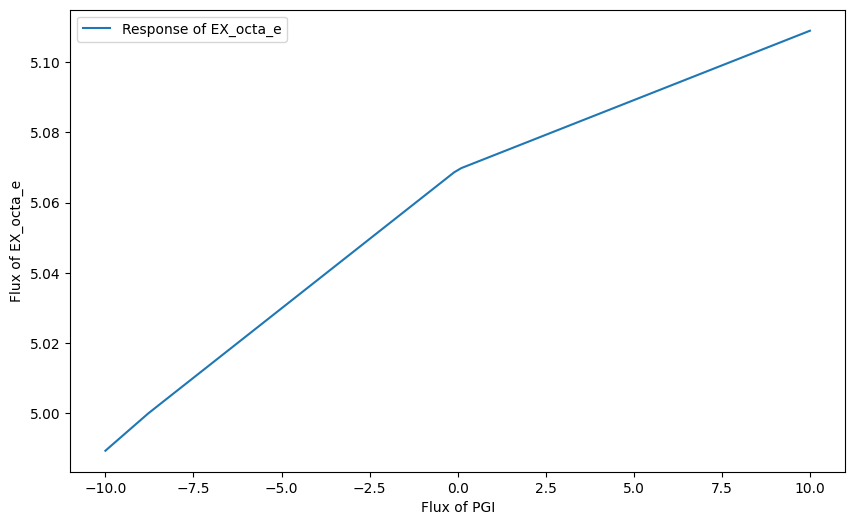

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cobra

model = read_sbml_model('./iML1515_octa_exporter_fade_del.xml')

# Target과 생산 반응을 정의합니다.
target_reaction = model.reactions.PGI
production_reaction = model.reactions.EX_octa_e
model.objective = production_reaction

# Target 플럭스의 변화 범위를 정의합니다.
target_fluxes = np.linspace(-10, 10, 100)
production_fluxes = []

# 각 Target 플럭스 값에 대해 생산 반응의 플럭스를 계산합니다.
for flux in target_fluxes:
    with model:
        # Target 플럭스를 설정합니다.
        target_reaction.bounds = (flux, flux)
        
        # 모델을 최적화하고 생산 반응의 플럭스를 저장합니다.
        solution = model.optimize()
        production_fluxes.append(solution.fluxes[production_reaction.id])

# 결과를 시각화합니다.
plt.figure(figsize=(10, 6))
plt.plot(target_fluxes, production_fluxes, label=f'Response of {production_reaction.id}')
plt.xlabel(f'Flux of {target_reaction.id}')
plt.ylabel(f'Flux of {production_reaction.id}')
plt.legend()
plt.show()




9.237263788363792 6.544043551195185


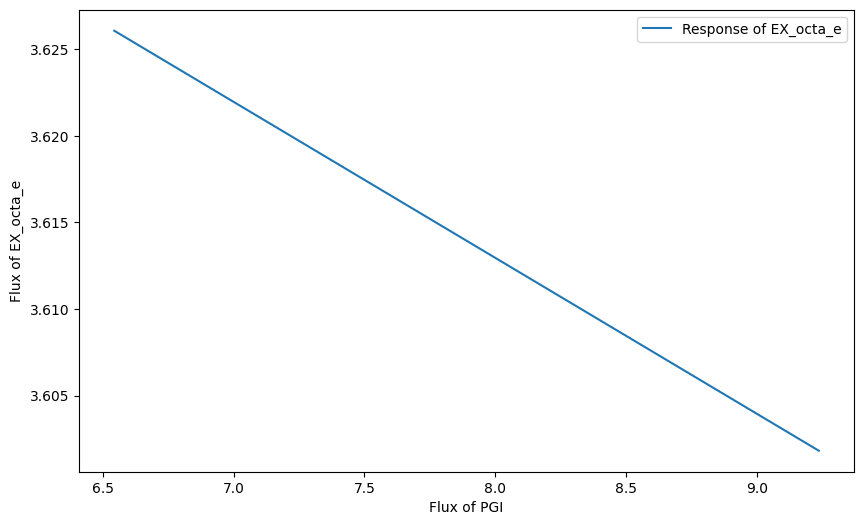

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import cobra

model = read_sbml_model('./iML1515_octa_exporter_fade_del.xml')

# Target과 생산 반응을 정의합니다.
target_reaction = model.reactions.FUM
production_reaction = model.reactions.EX_octa_e

# 최대 생물량을 계산합니다.
model.objective = model.reactions.BIOMASS_Ec_iML1515_core_75p37M
max_biomass = model.optimize().objective_value
model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.3 * max_biomass

target_reaction = model.reactions.PGI
# Target 반응의 최소 및 최대 플럭스를 계산합니다.
min_flux = model.optimize(objective_sense='minimize').fluxes[target_reaction.id]
max_flux = model.optimize(objective_sense='maximize').fluxes[target_reaction.id]
print(min_flux, max_flux)

# Target 플럭스의 변화 범위를 10단계로 나눕니다.
target_fluxes = np.linspace(min_flux, max_flux, 10)
production_fluxes = []

model.objective = production_reaction

# 각 Target 플럭스 값에 대해 생산 반응의 플럭스를 계산합니다.
for flux in target_fluxes:
    with model:
        # Target 플럭스를 설정합니다.
        target_reaction.bounds = (flux, flux)
        
        # 모델을 최적화하고 생산 반응의 플럭스를 저장합니다.
        solution = model.optimize()
        production_fluxes.append(solution.fluxes[production_reaction.id])

# 결과를 시각화합니다.
plt.figure(figsize=(10, 6))
plt.plot(target_fluxes, production_fluxes, label=f'Response of {production_reaction.id}')
plt.xlabel(f'Flux of {target_reaction.id}')
plt.ylabel(f'Flux of {production_reaction.id}')
plt.legend()
plt.show()

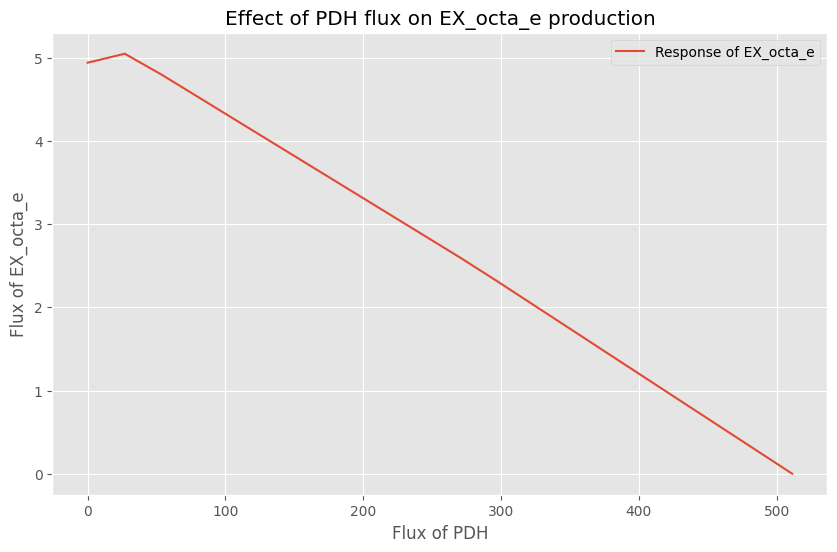

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import cobra
plt.style.use('ggplot')

# Genome-scale metabolic model을 로드합니다.
# (여기에서는 로컬 파일 경로를 사용하지 않고, toy model을 사용합니다.)
model = read_sbml_model('./iML1515_octa_exporter_fade_del.xml')

#glucose_uptake_rate = 3.457  # 예시 값입니다. 실제 실험 값으로 변경해야 합니다.
#model.reactions.EX_glc__D_e.bounds = (-glucose_uptake_rate, 1000)

# PPC와 ICL의 flux를 perturb하며 Thr 생산률을 최대화하는 분석을 수행합니다.
for reaction_id in ['PDH']:  # 실제 반응 ID로 변경해야 합니다.
    target_reaction = model.reactions.get_by_id(reaction_id)
    production_reaction = model.reactions.EX_octa_e  # Thr 생산 반응. 실제 ID로 변경해야 합니다.
    
    model.objective = reaction_id
    # Target 반응의 최소 및 최대 플럭스를 계산합니다.
    min_flux = model.optimize(objective_sense='minimize').fluxes[target_reaction.id]
    max_flux = model.optimize(objective_sense='maximize').fluxes[target_reaction.id]
    
    # Target 플럭스의 변화 범위를 10단계로 나눕니다.
    target_fluxes = np.linspace(min_flux, max_flux, 20)
    production_fluxes = []

    # 각 Target 플럭스 값에 대해 생산 반응의 플럭스를 계산합니다.
    for flux in target_fluxes:
        with model:
            # Target 플럭스를 설정합니다.
            target_reaction.bounds = (flux, flux)
            
            # 생산 반응률을 최대화하는 목적 함수로 설정합니다.
            model.objective = production_reaction
            
            # 모델을 최적화하고 생산 반응의 플럭스를 저장합니다.
            solution = model.optimize()
            production_fluxes.append(solution.fluxes[production_reaction.id])

    # 결과를 시각화합니다.
    plt.figure(figsize=(10, 6))
    plt.plot(target_fluxes, production_fluxes, label=f'Response of {production_reaction.id}')
    plt.xlabel(f'Flux of {target_reaction.id}')
    plt.ylabel(f'Flux of {production_reaction.id}')
    plt.legend()
    plt.title(f'Effect of {target_reaction.id} flux on {production_reaction.id} production')
    plt.show()
